In [20]:
# Cargar librerías necesarias
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Para visualizar las imágenes
import PIL
from PIL import Image

In [21]:
# Definir la ruta a tu proyecto (cambiar a la ruta correspondiente)
base_dir = './entrenamiento'  # Cambia esto a la ruta de tu proyecto con las carpetas 'leones', 'tigres' y 'pinguinos'

# Crear un generador de imágenes con normalización y división en entrenamiento/validación
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalizar los valores de los píxeles a [0, 1]
    validation_split=0.2)    # Reservar un 20% para validación

# Crear el generador de datos para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # Ajustar el tamaño de las imágenes a 224x224
    batch_size=32,           # Ajustar el tamaño del lote
    class_mode='categorical',
    subset='training')       # Usar este generador para entrenamiento

# Crear el generador de datos para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')     # Usar este generador para validación

# Mostrar las clases detectadas
print(f'Clases encontradas: {train_generator.class_indices}')

Found 2797 images belonging to 3 classes.
Found 698 images belonging to 3 classes.
Clases encontradas: {'elefante_train': 0, 'farfalla_train': 1, 'leon_train': 2}


In [22]:
#Carga de librerias
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
#Se establece una semilla para evitar distintos resultados
keras.utils.set_random_seed(812)
#Se establece un modelo neuronal
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))  # Aplanar la imagen
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax')) #3 es el numero de clases

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

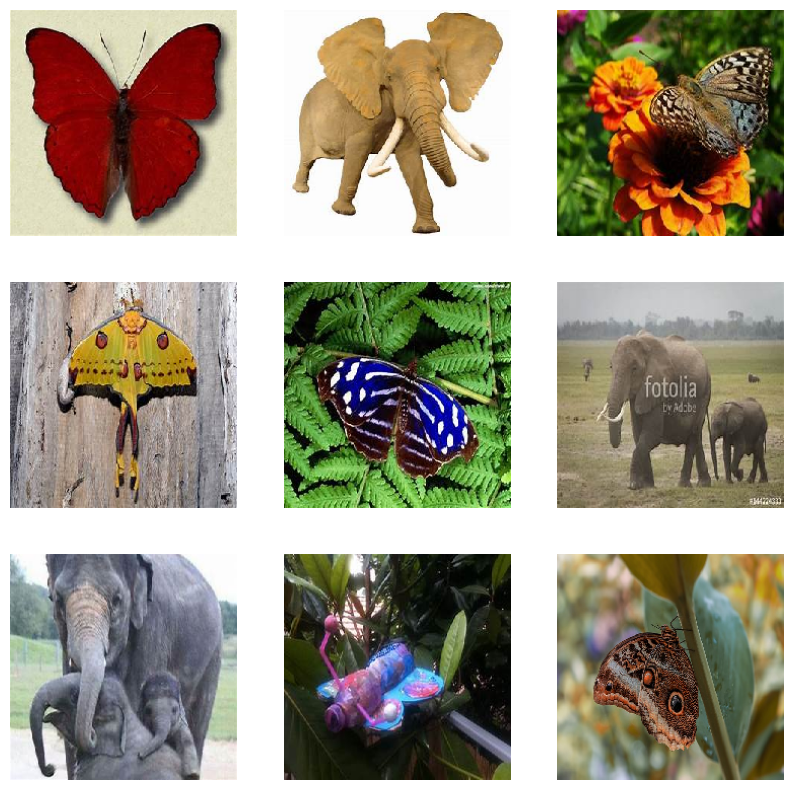

In [24]:
# Visualizar algunas imágenes del generador de entrenamiento
sample_training_images, _ = next(train_generator)  # Obtener un lote de imágenes

# Visualizar 9 imágenes del lote
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_training_images[i])
    plt.axis('off')
plt.show()

In [25]:
# Definir el modelo básico de CNN
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Tamaño de entrada: 224x224 con 3 canales de color
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Tres salidas porque tenemos 3 clases
])

# Compilar el modelo con el optimizador Adam
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

c:\Users\nob96\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entrenar el modelo
history = model.fit(
    train_generator,                    # Datos de entrenamiento
    epochs=10,                          # Ajustar el número de épocas según se necesite
    validation_data=validation_generator)  # Datos de validación


Epoch 1/10


c:\Users\nob96\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/88 ━━━━━━━━━━━━━━━━━━━━ 28s 411ms/step - accuracy: 0.4899 - loss: 2.1855

c:\Users\nob96\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - accuracy: 0.6142 - loss: 1.2258 - val_accuracy: 0.8395 - val_loss: 0.4082
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 399ms/step - accuracy: 0.8510 - loss: 0.3884 - val_accuracy: 0.8954 - val_loss: 0.2662
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 403ms/step - accuracy: 0.9017 - loss: 0.2531 - val_accuracy: 0.9054 - val_loss: 0.2339
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - accuracy: 0.9320 - loss: 0.1765 - val_accuracy: 0.9112 - val_loss: 0.2501
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 407ms/step - accuracy: 0.9637 - loss: 0.1091 - val_accuracy: 0.9155 - val_loss: 0.2300
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step - accuracy: 0.9739 - loss: 0.0702 - val_accuracy: 0.9069 - val_loss: 0.2958
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 410ms/step - accuracy: 0.9854 - loss: 0.0470 - val_accuracy: 0.8653 - val_loss: 0.5092
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 402ms/step - accuracy: 0.9582 - loss: 0.1350 - val_accuracy: 0.904

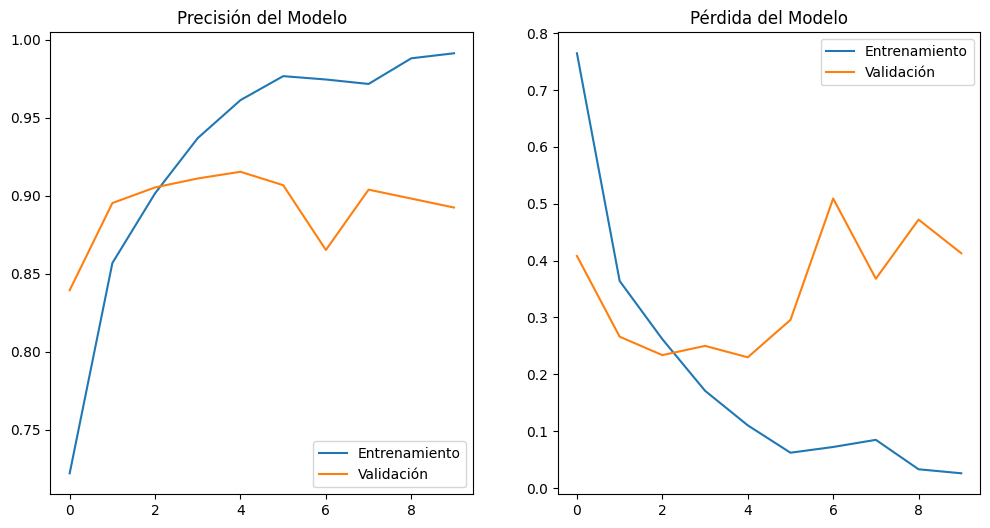

In [28]:
# Extraer los resultados de precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráficos para comparar precisión y pérdida
epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.legend(loc='upper right')
plt.title('Pérdida del Modelo')
plt.show()

In [31]:
# Evaluar el modelo en el conjunto de validación
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Precisión en el conjunto de validación: {test_acc*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9043 - loss: 0.3163
Precisión en el conjunto de validación: 89.26%


In [32]:
# Obtener las predicciones de todo el conjunto de validación
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir predicciones a clases
y_true = validation_generator.classes        # Obtener las etiquetas verdaderas

# Mostrar las primeras 10 predicciones y etiquetas verdaderas para verificar
print(f'Primeras 10 predicciones: {y_pred_classes[:10]}')
print(f'Primeras 10 etiquetas verdaderas: {y_true[:10]}')

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
Primeras 10 predicciones: [0 1 0 1 2 1 0 2 1 1]
Primeras 10 etiquetas verdaderas: [0 0 0 0 0 0 0 0 0 0]


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular las métricas para cada clase
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average=None)  # Precisión por clase
recall = recall_score(y_true, y_pred_classes, average=None)        # Recall por clase
f1 = f1_score(y_true, y_pred_classes, average=None)                # F1-score por clase

# Promedio de las métricas (usando average='macro' para calcular el promedio entre todas las clases)
precision_avg = precision_score(y_true, y_pred_classes, average='macro')
recall_avg = recall_score(y_true, y_pred_classes, average='macro')
f1_avg = f1_score(y_true, y_pred_classes, average='macro')

# Imprimir las métricas por clase y los promedios
print(f"Exactitud: {accuracy*100:.2f}%")
print("Precisión por clase:", precision)
print("Promedio de Precisión:", precision_avg)
print("Sensibilidad por clase:", recall)
print("Promedio de Sensibilidad:", recall_avg)
print("F1 Score por clase:", f1)
print("Promedio de F1 Score:", f1_avg)

# Reporte de clasificación completo
print("\nReporte de clasificación detallado:\n")
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

Exactitud: 42.26%
Precisión por clase: [0.36015326 0.55619597 0.08888889]
Promedio de Precisión: 0.33507937033724566
Sensibilidad por clase: [0.36153846 0.50789474 0.13793103]
Promedio de Sensibilidad: 0.33578807762110846
F1 Score por clase: [0.36084453 0.53094911 0.10810811]
Promedio de F1 Score: 0.3333005812577687

Reporte de clasificación detallado:

                precision    recall  f1-score   support

elefante_train       0.36      0.36      0.36       260
farfalla_train       0.56      0.51      0.53       380
    leon_train       0.09      0.14      0.11        58

      accuracy                           0.42       698
     macro avg       0.34      0.34      0.33       698
  weighted avg       0.44      0.42      0.43       698



In [34]:
from tensorflow.keras.preprocessing import image

# Cargar una nueva imagen para predicción
img_path = './entrenamiento/elefante_train/ea36b90d2bf1033ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efb4bb_640.jpg'  # Ruta de la imagen de prueba
img = image.load_img(img_path, target_size=(224, 224))  # Redimensionar la imagen a 224x224
img_array = image.img_to_array(img) / 255.0             # Normalizar los valores de píxeles
img_array = np.expand_dims(img_array, axis=0)           # Expandir las dimensiones para el modelo

# Realizar la predicción
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Imprimir la predicción
print(f'Predicción para la imagen cargada: Clase {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicción para la imagen cargada: Clase 0


In [36]:
# Importar tkinter para seleccionar el archivo
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Función para seleccionar una imagen
def cargar_imagen():
    root = tk.Tk()
    root.withdraw()  # Ocultar la ventana de tkinter
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.png *.jpeg")])
    return file_path

# Seleccionar la imagen desde el escritorio
img_path = cargar_imagen()
print(f"Imagen seleccionada: {img_path}")



Imagen seleccionada: C:/Users/nob96/OneDrive/Escritorio/eva1 MACHINE/modelo/farfalla_train/ea36b00828f6033ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg


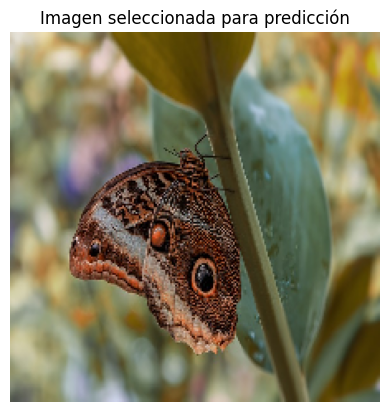

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicción para la imagen seleccionada: Clase 1 - farfalla_train


In [37]:
# Paso 2: Preprocesar y Hacer la Predicción
# Cargar y preprocesar la imagen seleccionada
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalizar la imagen
img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensiones para que coincida con el tamaño esperado

# Mostrar la imagen seleccionada
plt.imshow(np.squeeze(img_array))  # Eliminar dimensiones adicionales y mostrar
plt.title('Imagen seleccionada para predicción')
plt.axis('off')
plt.show()

# Realizar la predicción con el modelo entrenado
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Obtener las etiquetas desde el generador
labels = validation_generator.class_indices
label_map = dict((v, k) for k, v in labels.items())  # Invertir el diccionario de etiquetas para obtener {índice: nombre de la clase}
predicted_label = label_map[predicted_class]

# Imprimir la predicción
print(f'Predicción para la imagen seleccionada: Clase {predicted_class} - {predicted_label}')

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

# model = ...  # Carga o define tu modelo aquí
model.save('./entrenamiento/modelo')  # Guarda el modelo en un directorio
tfjs.converters.save_keras_model(model, './model_tfjs')  # Convierte el modelo a TensorFlow.js